
# Dimensionality Reduction — Hands‑On

**Course:** Data Analysis & Machine Learning for Physics  
**Focus:** PCA, SVD, t‑SNE, UMAP, Autoencoders (same dataset for all methods)  
**Dataset:** `sklearn.datasets.load_digits()` (1797 samples, 8×8 images → 64D feature vectors)

**What you'll do in ~60 minutes**
- Load and standardize the dataset (digits) — quick, reproducible, small but rich.
- Apply **PCA**: visualize 2‑D embedding, **explained variance ratio**, **cumulative variance**.
- Apply **SVD**: inspect **singular values (log‑scale)** and **cumulative energy**; connect to PCA.
- Apply **t‑SNE** and **UMAP**: study the effect of **hyperparameters** on neighborhood structure.
- Build a tiny **Autoencoder** with a 2‑D latent space and compare to PCA/t‑SNE/UMAP embeddings.

> This lab complements the slide deck *“Dimensionality Reduction: PCA, SVD, t‑SNE, UMAP, and Autoencoders.”*



## 0) Setup

> You can run this notebook as-is. If `umap-learn` or `tensorflow` aren't installed, run the first cell below.


In [1]:

# Optional: install extras if missing (uncomment if needed in your environment)
# %pip install -q umap-learn tensorflow
# If you prefer PyTorch, you can use it instead of TensorFlow for the autoencoder.


In [2]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# UMAP optional import (will raise if not installed)
try:
    import umap
    UMAP_AVAILABLE = True
except Exception as e:
    UMAP_AVAILABLE = False
    print("UMAP not available. Install with `pip install umap-learn` to run UMAP cells.")

# TensorFlow optional import for the autoencoder
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
except Exception as e:
    TF_AVAILABLE = False
    print("TensorFlow not available. Install with `pip install tensorflow` to run Autoencoder cells.")

RNG = 42
np.random.seed(RNG)



## 1) Load & Standardize the Dataset

We will use `sklearn.datasets.load_digits()`. It provides 1797 images of handwritten digits, each of size 8×8, flattened into 64‑dim vectors.


In [3]:

digits = load_digits()
X = digits.data.astype(np.float64)   # shape: (n_samples, 64)
y = digits.target                    # labels for coloring only
images = digits.images               # original 8x8 images

# Standardize (zero-mean, unit-variance) — good practice for many methods
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

print(f"X shape: {X.shape}, standardized: {X_std.shape}, labels: {y.shape}")


X shape: (1797, 64), standardized: (1797, 64), labels: (1797,)



---

## 2) Principal Component Analysis (PCA)

**Exercise 2.1 (5–7 min).**  
Fit PCA on `X_std` and:
1. Produce a **2‑D scatter** of the first two principal components (PC1 vs PC2) colored by digit label.
2. Plot the **scree plot** of explained variance ratio and the **cumulative explained variance**.  
3. Report the **minimum number of components** to explain at least **95%** of the variance.

<details><summary><strong>Why this matters (physics intuition)</strong></summary>
PCA diagonalizes the covariance matrix — analogous to finding **eigenmodes** (normal modes) of a system. The eigenvalues represent variances captured by each mode.
</details>


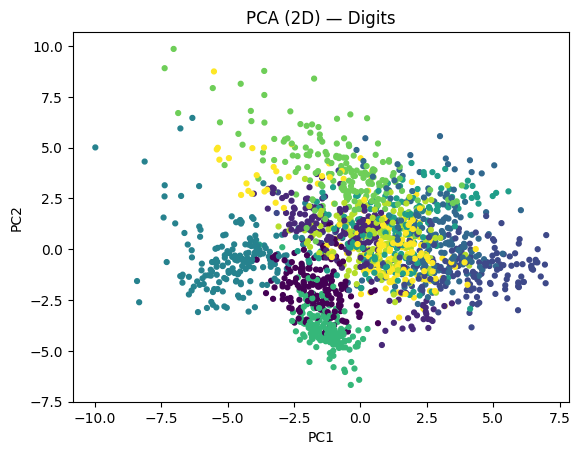

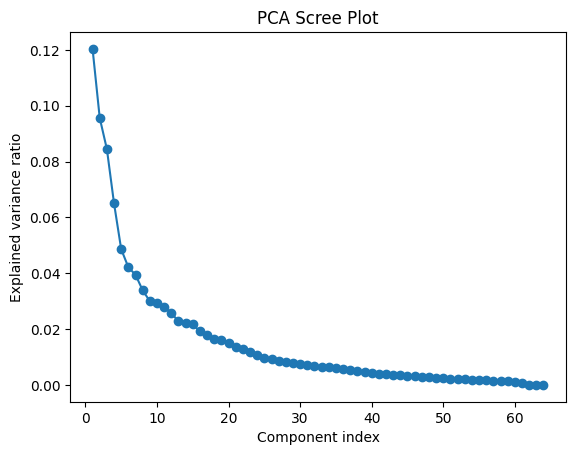

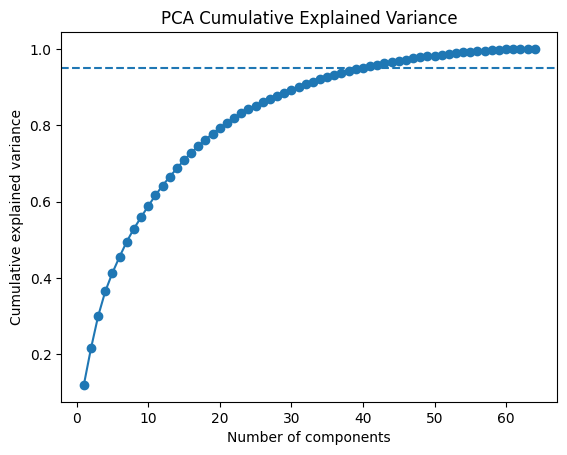

Minimum number of PCs to reach ≥95% variance: k = 40


In [4]:

# ===== Solution 2.1 =====
pca_full = PCA(n_components=64, random_state=RNG)
X_pca_full = pca_full.fit_transform(X_std)

# 2D embedding
pca_2 = PCA(n_components=2, random_state=RNG)
X_pca_2d = pca_2.fit_transform(X_std)

plt.figure()
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, s=12)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2D) — Digits")
plt.show()

# Scree & cumulative explained variance
expl_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

plt.figure()
plt.plot(np.arange(1, len(expl_var)+1), expl_var, marker='o')
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio")
plt.title("PCA Scree Plot")
plt.show()

plt.figure()
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Cumulative Explained Variance")
plt.axhline(0.95, linestyle='--')
plt.show()

k95 = int(np.argmax(cum_var >= 0.95)) + 1
print(f"Minimum number of PCs to reach ≥95% variance: k = {k95}")



---

## 3) Singular Value Decomposition (SVD)

**Exercise 3.1 (7–8 min).**  
Compute the compact SVD of the **centered** data `X_centered = X_std` (already zero-mean) using `np.linalg.svd`:
1. Plot the **singular values** \(\sigma_i\) on a **log scale**.
2. Plot the **cumulative energy** defined as  
\[ E(k) = \frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^r \sigma_i^2} \]  
and report the **k** for which **E(k) ≥ 0.95**.  
3. Verify: PCA eigenvalues are proportional to \(\sigma_i^2/(n-1)\).

<details><summary><strong>Connection to PCA</strong></summary>
For centered data, PCA directions equal right singular vectors of **X**, and PCA variances equal \(\sigma_i^2/(n-1)\). Many libraries implement PCA via SVD for numerical stability.
</details>


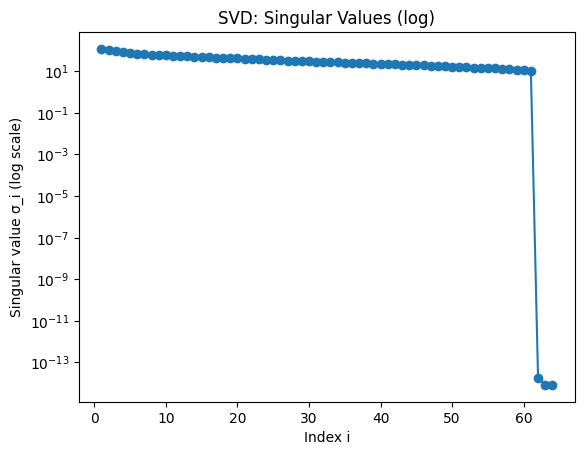

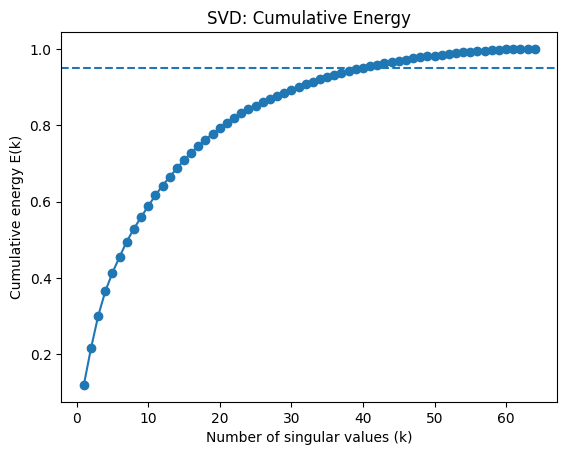

Minimum k to reach ≥95% energy with SVD: k = 40
First 5 PCA variances (from PCA):      [7.3448 5.8355 5.154  3.9662 2.9663]
First 5 variances from SVD (scaled):  [7.3448 5.8355 5.154  3.9662 2.9663]


In [5]:

# ===== Solution 3.1 =====
# X_std is already centered and scaled (zero mean, unit variance)
U, S, Vt = np.linalg.svd(X_std, full_matrices=False)
r = len(S)

# singular values (log scale)
plt.figure()
plt.plot(np.arange(1, r+1), S, marker='o')
plt.yscale('log')
plt.xlabel("Index i")
plt.ylabel("Singular value σ_i (log scale)")
plt.title("SVD: Singular Values (log)")
plt.show()

# cumulative energy
S2 = S**2
cum_energy = np.cumsum(S2) / np.sum(S2)

plt.figure()
plt.plot(np.arange(1, r+1), cum_energy, marker='o')
plt.xlabel("Number of singular values (k)")
plt.ylabel("Cumulative energy E(k)")
plt.title("SVD: Cumulative Energy")
plt.axhline(0.95, linestyle='--')
plt.show()

k95_svd = int(np.argmax(cum_energy >= 0.95)) + 1
print(f"Minimum k to reach ≥95% energy with SVD: k = {k95_svd}")

# Check proportionality between PCA eigenvalues and sigma^2/(n-1)
# (they won’t be identical if using StandardScaler with unit variance per feature,
# but proportionality across components still holds conceptually)
eig_from_svd = S2/(X_std.shape[0]-1)
print("First 5 PCA variances (from PCA):     ", np.round(PCA(n_components=5, random_state=RNG).fit(X_std).explained_variance_, 4))
print("First 5 variances from SVD (scaled): ", np.round(eig_from_svd[:5], 4))



---

## 4) t‑SNE (t‑distributed Stochastic Neighbor Embedding)

**Exercise 4.1 (8–10 min).**  
Run t‑SNE on `X_std` with different **perplexities** and compare the 2‑D embeddings:

- Perplexities: `[5, 30, 50]` (keep other params default except `random_state=42`)
- For each run, make a scatter plot colored by labels and briefly note cluster compactness and separation.

> **Tip:** t‑SNE focuses on *local* neighborhood preservation and is sensitive to hyperparameters. Expect different layouts across runs.


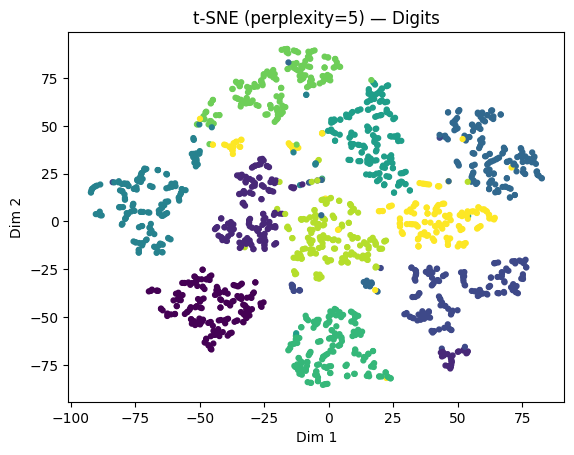

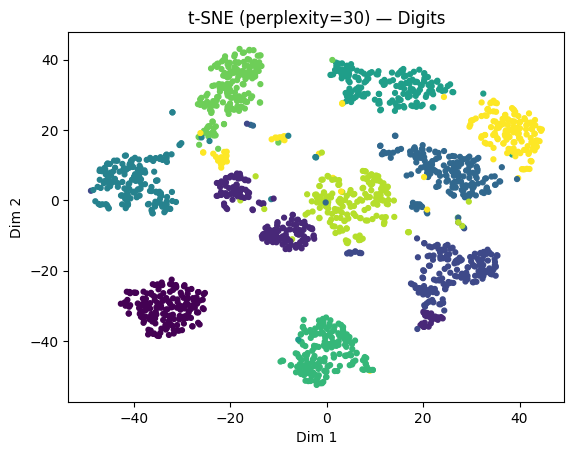

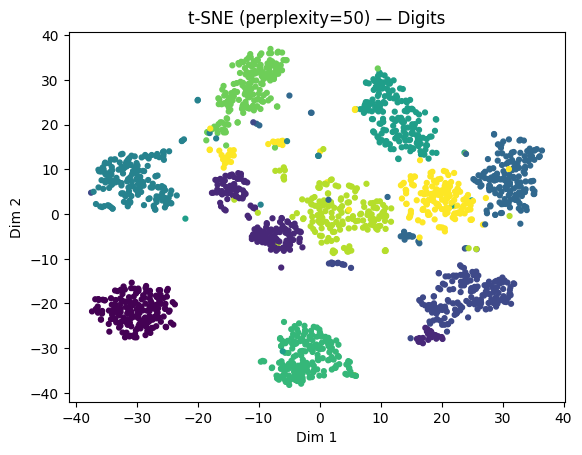

In [6]:

# ===== Solution 4.1 =====
perplexities = [5, 30, 50]
for perp in perplexities:
    tsne = TSNE(n_components=2, perplexity=perp, random_state=RNG, init='pca')
    X_tsne = tsne.fit_transform(X_std)
    plt.figure()
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=12)
    plt.title(f"t-SNE (perplexity={perp}) — Digits")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()



---

## 5) UMAP (Uniform Manifold Approximation and Projection)

**Exercise 5.1 (8–10 min).**  
If available, run UMAP with different **n_neighbors** and **min_dist**, and compare the embeddings:
- Try pairs `(n_neighbors, min_dist)` in `[(5, 0.1), (15, 0.1), (50, 0.5)]`.
- Discuss local cluster separation vs global structure preservation.

> **Note:** UMAP is often faster and gives more stable global geometry than t‑SNE, but hyperparameters still matter.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


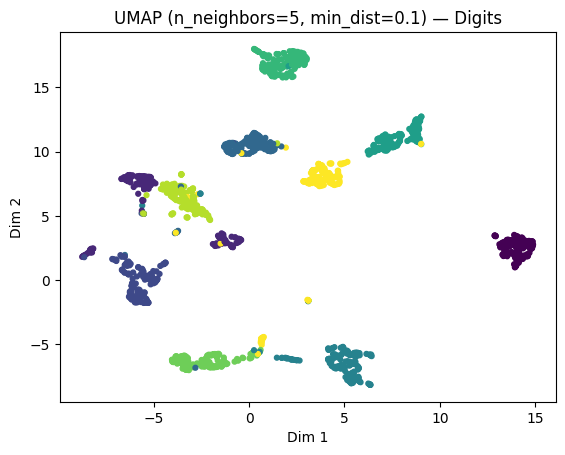

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


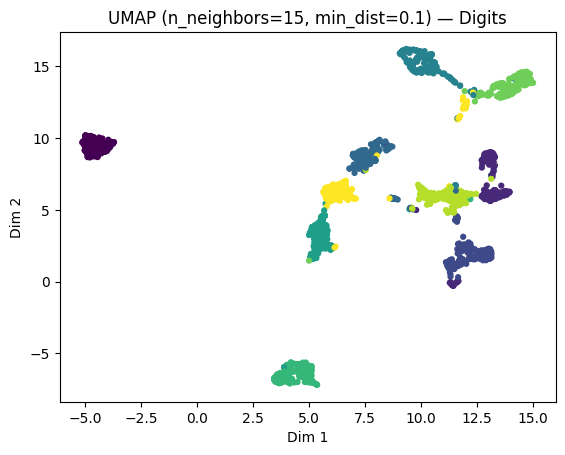

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


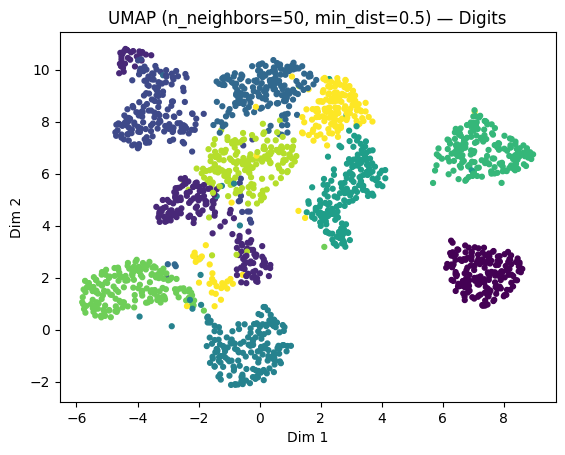

In [7]:

# ===== Solution 5.1 =====
if UMAP_AVAILABLE:
    settings = [(5, 0.1), (15, 0.1), (50, 0.5)]
    for n_neighbors, min_dist in settings:
        umap_model = umap.UMAP(
            n_components=2,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            random_state=RNG,
        )
        X_umap = umap_model.fit_transform(X_std)
        plt.figure()
        plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=12)
        plt.title(f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist}) — Digits")
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")
        plt.show()
else:
    print("UMAP not installed. Install with `pip install umap-learn` to run this section.")



---

## 6) Autoencoder (Neural Dimensionality Reduction)

We will build a tiny fully connected autoencoder with a **2‑D latent space**.

**Exercise 6.1 (10–12 min).**
1. Define an encoder–decoder with architecture 64→32→**2** (latent)→32→64 using ReLU except for the output (sigmoid).
2. Train it to reconstruct standardized inputs (`X_std`).
3. Extract the 2‑D latent embedding and plot it colored by labels.
4. Compare **reconstruction MSE** vs a **2‑D PCA** reconstruction.

> If `tensorflow` is not available, install it or skip to the comparative discussion below.


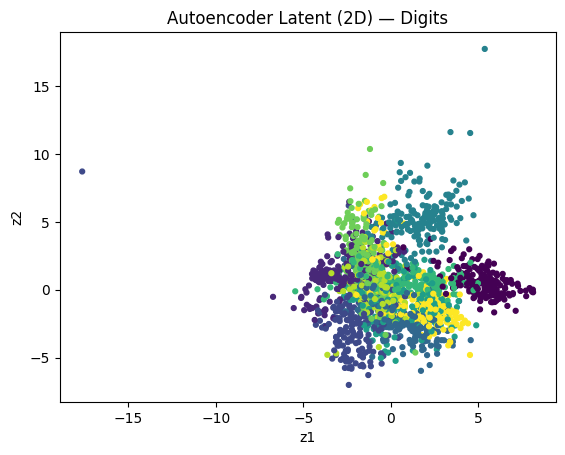

Reconstruction MSE — Autoencoder(2D): 0.72593
Reconstruction MSE — PCA(2D):         0.74730


In [8]:

# ===== Solution 6.1 =====
if TF_AVAILABLE:
    input_dim = X_std.shape[1]

    encoder = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(2, activation=None)  # 2-D latent
    ])

    decoder = keras.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(input_dim, activation="linear")  # linear works well with standardized inputs
    ])

    inputs = keras.Input(shape=(input_dim,))
    z = encoder(inputs)
    outputs = decoder(z)
    autoencoder = keras.Model(inputs, outputs)
    autoencoder.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

    history = autoencoder.fit(
        X_std, X_std,
        epochs=20,
        batch_size=256,
        verbose=0,
        validation_split=0.1
    )

    # Latent embedding
    X_latent = encoder.predict(X_std, verbose=0)
    plt.figure()
    plt.scatter(X_latent[:, 0], X_latent[:, 1], c=y, s=12)
    plt.title("Autoencoder Latent (2D) — Digits")
    plt.xlabel("z1"); plt.ylabel("z2")
    plt.show()

    # Reconstruction errors vs PCA-2 reconstruction
    X_rec_ae = autoencoder.predict(X_std, verbose=0)
    ae_mse = np.mean((X_std - X_rec_ae)**2)

    pca2 = PCA(n_components=2, random_state=RNG)
    Z2 = pca2.fit_transform(X_std)
    X_rec_pca2 = pca2.inverse_transform(Z2)
    pca2_mse = np.mean((X_std - X_rec_pca2)**2)

    print(f"Reconstruction MSE — Autoencoder(2D): {ae_mse:.5f}")
    print(f"Reconstruction MSE — PCA(2D):         {pca2_mse:.5f}")
else:
    print("TensorFlow not installed. Install with `pip install tensorflow` to run the Autoencoder section.")



---

## 7) Comparative Discussion (5–7 min)

**Pros/Cons quick matrix (for this dataset):**
- **PCA** — fast, interpretable; linear; good for variance capture and denoising.
- **SVD** — general factorization; connects cleanly to PCA; singular values show energy spectrum.
- **t‑SNE** — excellent local cluster separation; stochastic layouts; sensitive to perplexity.
- **UMAP** — often faster, balances local & global; sensitive to `n_neighbors`/`min_dist`.
- **Autoencoders** — flexible nonlinear reduction; needs training; architecture & optimization matter.

**Prompts:**
- Does your PCA scree plot show a “knee”? Where would you truncate?
- Which method best separates classes? Which preserves global distances better?
- How do t‑SNE/UMAP hyperparameters affect cluster compactness vs. continuity?
- Compare reconstruction errors: AE(2D) vs PCA(2D). What might improve the AE (depth, nonlinearities, epochs)?



### (Optional) Visualize Reconstructions

Pick a few samples and compare original vs. reconstructions from PCA‑k and Autoencoder.


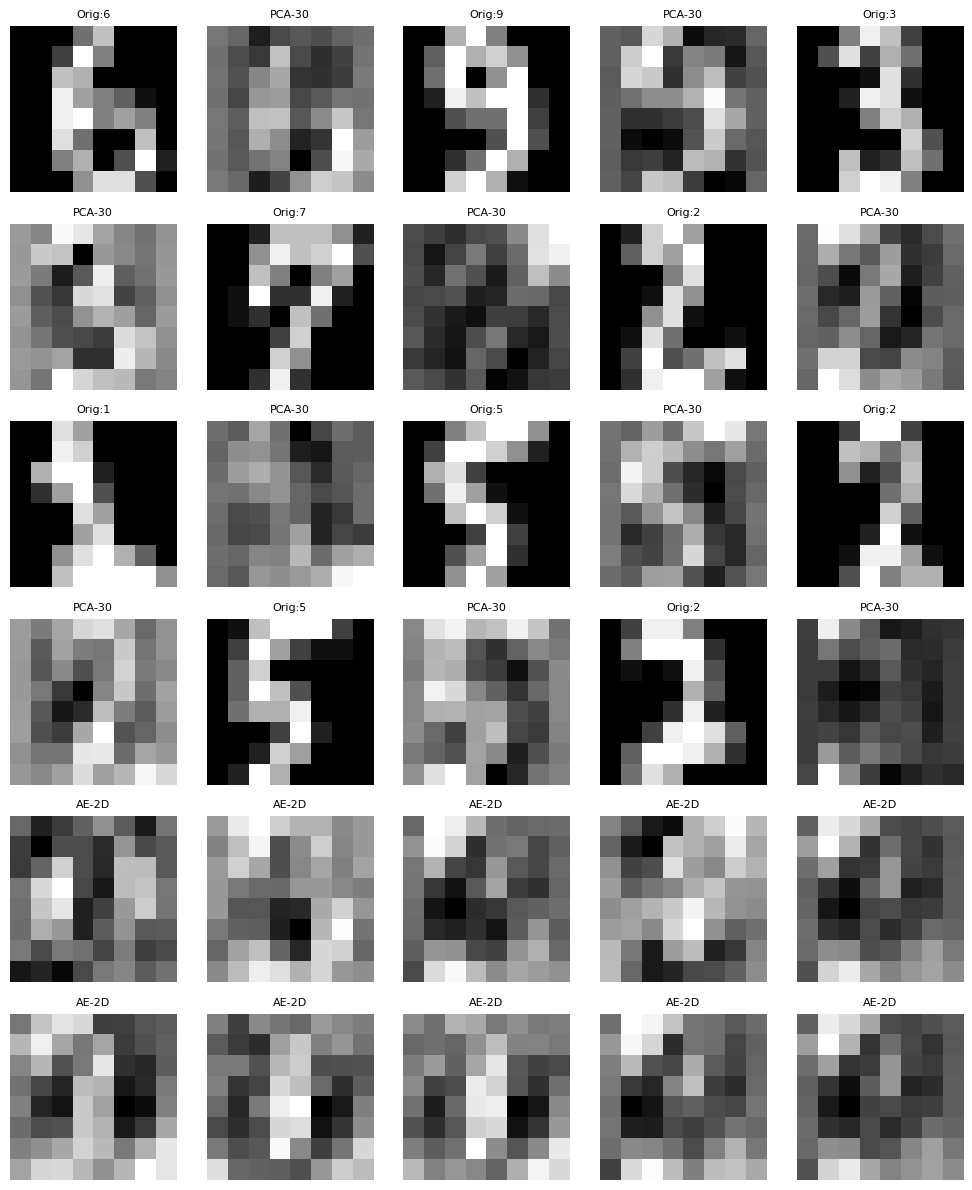

In [9]:

# Optional visualization of reconstructions (requires matplotlib subplots)
def show_image_grid(imgs, titles, ncols=5, cmap='gray'):
    import math
    n = len(imgs)
    nrows = math.ceil(n/ncols)
    plt.figure(figsize=(ncols*2, nrows*2))
    for i, (im, t) in enumerate(zip(imgs, titles), 1):
        ax = plt.subplot(nrows, ncols, i)
        ax.imshow(im, cmap=cmap, interpolation='nearest')
        ax.set_title(t, fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Choose a few indices
idxs = np.random.choice(len(images), size=10, replace=False)

# PCA-30 reconstruction (often good on digits)
pca30 = PCA(n_components=30, random_state=RNG).fit(X_std)
X_rec_pca30 = pca30.inverse_transform(pca30.transform(X_std))

examples = []
titles = []
for i in idxs:
    examples.append(images[i])
    titles.append(f"Orig:{y[i]}")
    examples.append(X_rec_pca30[i].reshape(8,8))
    titles.append("PCA-30")

if TF_AVAILABLE:
    # AE reconstruction (if trained above)
    try:
        X_rec_ae = X_rec_ae  # from earlier cell
    except NameError:
        # train briefly if not present
        input_dim = X_std.shape[1]
        encoder = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(32, activation="relu"),
            layers.Dense(2, activation=None)
        ])
        decoder = keras.Sequential([
            layers.Input(shape=(2,)),
            layers.Dense(32, activation="relu"),
            layers.Dense(input_dim, activation="linear")
        ])
        inputs = keras.Input(shape=(input_dim,))
        z = encoder(inputs)
        outputs = decoder(z)
        autoencoder = keras.Model(inputs, outputs)
        autoencoder.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
        autoencoder.fit(X_std, X_std, epochs=10, batch_size=256, verbose=0)
        X_rec_ae = autoencoder.predict(X_std, verbose=0)

    for i in idxs:
        examples.append(X_rec_ae[i].reshape(8,8))
        titles.append("AE-2D")

show_image_grid(examples, titles, ncols=5)
